In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import kendalltau, spearmanr
import scipy.stats
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [18]:
def read_file(filename):
    # Joined path and filename using os.path.join() to make it more robust and platform-independent.
    path = os.path.join(filename)
    # Used read_table() instead of read_csv() as it is faster and more memory-efficient when reading tab-delimited files.
    df = pd.read_table(path, index_col=[0,1])
    return df

In [19]:
def get_failure(df):
    # check if total error is more than 10 kcal/mol and flag faliures
    df['acceptance_total_err'] = np.where(df['error(total)'] > 10, False, True)
    # check if contirubution of restraints in the complex is more 
    # than 2.5 times the median for all replicas and compunds of the condition
    df['acceptance_site_contr'] = np.where(df['ΔG(site,c+o+a+r)'] > 2.5 * df['ΔG(site,c+o+a+r)'].median(), True, False)
    # check which replica is failed
    df['acceptance_final'] = np.where(df['acceptance_site_contr'] & df['acceptance_total_err'], True, False)
    fail = df[df['acceptance_final'] == False]
     
#     return df

In [20]:
def write_accept_reject(df, dir_name, out_name):
    # Initialize lists to store cmpnd and rep for acceptance_final as True and False
    cmpnd_list_acceptance_true = []
    rep_list_acceptance_true = []
    cmpnd_list_acceptance_false = []
    rep_list_acceptance_false = []
    
    # Loop through the rows of the dataframe and append cmpnd and rep to the appropriate lists
    for index, row in df.iterrows():
        # change the rep to match the directory names in repo
        rep_name = index[1]
        new_rep_name = rep_name[3] + '-' + rep_name
        
        cmpnd_name = index[0]
        if cmpnd_name == 'theophylline':
            new_cmpnd_name = '2-theophylline'
        elif cmpnd_name == '1_methylxanthine':
            new_cmpnd_name = '3-1_methylxanthine'
        elif cmpnd_name == '3_methylxanthine':
            new_cmpnd_name = '4-3_methylxanthine'
        elif cmpnd_name == 'hypoxanthine':
            new_cmpnd_name = '5-hypoxanthine'
        elif cmpnd_name == 'xanthine':
            new_cmpnd_name = '6-xanthine'
        elif cmpnd_name == 'caffeine':
            new_cmpnd_name = '7-caffeine'
        
        if row['acceptance_final'] == True:
            cmpnd_list_acceptance_true.append(new_cmpnd_name)
            rep_list_acceptance_true.append(new_rep_name)
        else:
            cmpnd_list_acceptance_false.append(new_cmpnd_name)
            rep_list_acceptance_false.append(new_rep_name)
    
    accept_file_name = './accept_reject_files/' + out_name + '_accept.txt'
    with open(accept_file_name, 'w') as file:
        for cmpnd, rep in zip(cmpnd_list_acceptance_true, rep_list_acceptance_true):
            entry = os.path.join(cmpnd,dir_name,rep)
            file.write(f"{entry}\t")
            
    reject_file_name = './accept_reject_files/' + out_name + '_reject.txt'
    with open(reject_file_name, 'w') as file:
        for cmpnd, rep in zip(cmpnd_list_acceptance_false, rep_list_acceptance_false):
            entry = os.path.join(cmpnd,dir_name,rep)
            file.write(f"{entry}\t")

In [21]:
# This function takes in a pandas DataFrame, `df`, and an offset value as input
def get_mean_std(df, offset):
    # A list of compound names to extract
    cmpnd_list = [ 'theophylline', '3_methylxanthine', 'xanthine', '1_methylxanthine', 'hypoxanthine', 'caffeine' ]
    # Extract a subset of the DataFrame where the 'acceptance_final' column is True and only include the 'ΔG(total)' column
    df2 = df.loc[df['acceptance_final'] == True, 'ΔG(total)']
    # Create empty arrays to store the mean and standard deviation of each compound's measurements
    mean_ = np.zeros(6)
    std_ = np.zeros(6)
    # iterate through 6 compunds
    for i in range(6):
        # chekc if we have 3 accepted replicas and print the Error message otherwise
        if df2.loc[cmpnd_list[i]].size != 3:
            print('Error, number of accpeted reps is not three in: ', cmpnd_list[i])
            mean_[i] = df2.loc[cmpnd_list[i]].mean()
            std_[i] = df2.loc[cmpnd_list[i]].std()
        else:
            mean_[i] = df2.loc[cmpnd_list[i]].mean()
            std_[i] = df2.loc[cmpnd_list[i]].std()

    # add the offset value to be added to all the averaged values (non-zero only for bb colvar restrains)
    mean_ += offset    
    return mean_, std_

In [22]:
def get_stats(calc_mean):
    ###########    ['theo','mth3','xan','mth1','hyp','caf'])
    exp = np.array([-8.86, -7.77, -6.91, -6.88, -5.88, -3.35])
    r_pearson = scipy.stats.pearsonr(exp, calc_mean)
    kt, p_value = kendalltau(exp, calc_mean)
    sr, p_value = spearmanr(exp, calc_mean)
    return r_pearson[0], kt, sr

In [23]:
def plotting(mean, std, file_dict, key, method_id):
    ###########    ['theo','mth3','xan','mth1','hyp','caf'])
    exp = np.array([-8.86, -7.77, -6.91, -6.88, -5.88, -3.35])
    r, kt, sr = get_stats(mean)

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(exp, mean)
    # mean absolute error & Root mean squared error
    MAE = np.mean(np.abs(exp-mean))
    RMSE = np.sqrt(np.mean((exp-mean)**2))
    file_dict[key].append(MAE)
    file_dict[key].append(RMSE)
    file_dict[key].append(r)
    file_dict[key].append(kt)
    file_dict[key].append(sr)
    
    
    # Set the figure size
    fig, axs = plt.subplots(1, 1)
    # set the path and file name based on the file_dict keys
    fig_name = os.path.join('./new_figs/', 'method{}_'.format(method_id) + key + '.pdf')
    # Plot the data with error bars representing the standard deviation of the 2 measurements
    mark = ["o", "s", "*", "p", "d", "X"]
    leg = ["Theophylline", "3-methylxanthine", "Xanthine", "1-methylxanthine", "Hypoxanthine", "Caffeine"]
    for x_, y_, yerror_, mark_, leg_ in zip(exp,mean,std,mark,leg):
        plt.errorbar(x_,y_,yerr=yerror_, fmt=mark_, markersize=10, capsize=6)
    
    # Plot identity line
    x_id = np.linspace(-20,20,100)
    y1 = x_id + 1
    y2 = x_id - 1
    y3 = x_id + 2
    y4 = x_id - 2
    plt.plot(x_id,x_id,'--',color="C7")
    axs.fill_between(x_id, y1, y2, color= 'darkgrey', alpha=0.2)
    axs.fill_between(x_id, y3, y4, color= 'darkgrey', alpha=0.15)
    
    # Create an array of x values for the fitted line
    x = np.array([-16, 0])
    # Plot the fitted line
    plt.plot(x, slope*x + intercept)
    
    # add the stats as legend
    plt.plot([],[],color='k',label=r'MAE = %2.1f'%MAE)
    plt.plot([],[],color='k',label=r'RMSE = %2.1f'%RMSE)    
    plt.plot([],[],color='k',label=r'r = %2.1f'%r)
    plt.plot([],[],color='k',label=r'$\tau$ = %2.1f' %kt)
    plt.plot([],[],color='k',label=r'$\rho$ = %2.1f' %sr)
    
    plt.xlim(-16,0)
    plt.ylim(-16,0)
    
    # Add labels to the axes and a title to the plot
    plt.xticks(fontsize=14)
    ytick_ = [-16, -14,-12, -10, -8, -6, -4,-2,0]
    plt.yticks(ytick_,fontsize=14)
    plt.xlabel(r"$\Delta$G$_{exp}$ (kcal/mol)", fontsize=18)
    plt.ylabel(r"$\Delta$G$_{calc}$ (kcal/mol)", fontsize=18)
    axs.set_aspect('equal', 'box')
    axs.set(xlim=(-16, 0), ylim=(-16, 0))
    axs.xaxis.set_minor_locator(MultipleLocator(1))
    axs.yaxis.set_minor_locator(MultipleLocator(1))
    
    l = axs.legend(handlelength=0, handletextpad=0,
                              labelcolor='linecolor',fontsize=16, 
                              loc='upper left')
    for item in l.legendHandles:
        item.set_visible(False)
        
    plt.rcParams['axes.titley'] = 1.05
    
    # Construct title
    title = "METHOD {}: \n{}".format(method_id, file_dict[key][7])
    plt.title(title, fontsize=18)
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()
    return file_dict

def plotting_mmgbsa(mean, std, file_dict, key, method_id):
    ###########    ['theo','mth3','xan','mth1','hyp','caf'])
    exp = np.array([-8.86, -7.77, -6.91, -6.88, -5.88, -3.35])
    r, kt, sr = get_stats(mean)

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(exp, mean)
    # mean absolute error & Root mean squared error
    MAE = np.mean(np.abs(exp-mean))
    RMSE = np.sqrt(np.mean((exp-mean)**2))
    file_dict[key].append(MAE)
    file_dict[key].append(RMSE)
    file_dict[key].append(r)
    file_dict[key].append(kt)
    file_dict[key].append(sr)
    
    
    # Set the figure size
    fig, axs = plt.subplots(1, 1)
    # set the path and file name based on the file_dict keys
    fig_name = os.path.join('./new_figs/', 'method{}_'.format(method_id) + key + '.pdf')
    # Plot the data with error bars representing the standard deviation of the 2 measurements
    mark = ["o", "s", "*", "p", "d", "X"]
    leg = ["Theophylline", "3-methylxanthine", "Xanthine", "1-methylxanthine", "Hypoxanthine", "Caffeine"]
    for x_, y_, yerror_, mark_, leg_ in zip(exp,mean,std,mark,leg):
        plt.errorbar(x_,y_,yerr=yerror_, fmt=mark_, markersize=10, capsize=6)
    
    # Plot identity line
    x_id = np.linspace(-22,22,100)
    y1 = x_id + 1
    y2 = x_id - 1
    y3 = x_id + 2
    y4 = x_id - 2
    plt.plot(x_id,x_id,'--',color="C7")
    axs.fill_between(x_id, y1, y2, color= 'darkgrey', alpha=0.2)
    axs.fill_between(x_id, y3, y4, color= 'darkgrey', alpha=0.15)
    
    # Create an array of x values for the fitted line
    x = np.array([-22, -2])
    # Plot the fitted line
    plt.plot(x, slope*x + intercept)
    
    # add the stats as legend
    plt.plot([],[],color='k',label=r'MAE = %2.1f'%MAE)
    plt.plot([],[],color='k',label=r'RMSE = %2.1f'%RMSE)    
    plt.plot([],[],color='k',label=r'r = %2.1f'%r)
    plt.plot([],[],color='k',label=r'$\tau$ = %2.1f' %kt)
    plt.plot([],[],color='k',label=r'$\rho$ = %2.1f' %sr)
    
#     plt.xlim(-14,-2)
#     plt.ylim(-14,-2)
    
    # Add labels to the axes and a title to the plot
    xtick_ = [-22,-18,-14,-10,-6,-2]
    plt.xticks(xtick_,fontsize=14)#,rotation=20)
    ytick_ = [-22,-18,-14,-10,-6,-2]
    plt.yticks(ytick_,fontsize=14)
    plt.xlabel(r"$\Delta$G$_{exp}$ (kcal/mol)", fontsize=18)
    plt.ylabel(r"$\Delta$G$_{calc}$ (kcal/mol)", fontsize=18)
    axs.set_aspect('equal', 'box')
    axs.set(xlim=(-22, -2), ylim=(-22, -2))
    axs.xaxis.set_minor_locator(MultipleLocator(1))
    axs.yaxis.set_minor_locator(MultipleLocator(1))
    
    l = axs.legend(handlelength=0, handletextpad=0,
                              labelcolor='linecolor',fontsize=16, 
                              loc='upper left')
    for item in l.legendHandles:
        item.set_visible(False)
        
    plt.rcParams['axes.titley'] = 1.05
    
    # Construct title
    title = "METHOD {}:\n{}".format(method_id, file_dict[key][7])
    plt.title(title, fontsize=18)
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()
    return file_dict

In [24]:
file_dict = {
    #                                  salt cond.   # Mg   water.  lig ff    windows         BB rest. offset         title                     Dir name                       Condition ID                    
    '55_NaCl_0Mg_TP3_GAF_40_1ns_unres':['55 NaCl',     '0', 'TIP3P', 'GAFF2', '40 win, 1 ns/win', 'No', 0,   "\n55 mM NaCl & 0 Mg$^{2+}$",   '4-55NaCl/1-40winCmplx_30winLig', '1'],
    '55_NaCl_2Mg_TP3_GAF_40_1ns_unres':['55 NaCl',     '2', 'TIP3P', 'GAFF2', '40 win, 1 ns/win', 'No', 0,   "\n55 mM NaCl & 2 Mg$^{2+}$",   '3-55NaCl_Mg/1-40winCmplx_30winLig', '2'],
    '55_NaCl_3Mg_TP3_GAF_40_1ns_unres':['55 NaCl',     '3', 'TIP3P', 'GAFF2', '40 win, 1 ns/win', 'No', 0,   "\n55 mM NaCl & 3 Mg$^{2+}$",   '1-55NaCl_3Mg/1-40winCmplx_30winLig', '3'],
    #
    '55_NaCl_0Mg_TP3_GAF_40_1ns_BBres':['55 NaCl',     '0', 'TIP3P', 'GAFF2', '40 win, 1 ns/win','Yes', 9.4, "55 mM NaCl & 0 Mg$^{2+}$\nw/ backbone restraints contribution", '9-5NaCl_bb_colvar/1-40winCmplx_30winLig', '4'],
    '55_NaCl_2Mg_TP3_GAF_40_1ns_BBres':['55 NaCl',     '2', 'TIP3P', 'GAFF2', '40 win, 1 ns/win','Yes', 9.7, "55 mM NaCl & 2 Mg$^{2+}$\nw/ backbone restraints contribution", '8-5NaCl_Mg_bb_colvar/1-40winCmplx_30winLig', '5'],
    '55_NaCl_3Mg_TP3_GAF_40_1ns_BBres':['55 NaCl',     '3', 'TIP3P', 'GAFF2', '40 win, 1 ns/win','Yes', 10,  "55 mM NaCl & 3 Mg$^{2+}$\nw/ backbone restraints contribution", '4-55NaCl_3Mg_bb_colvar/1-40winCmplx_30winLig', '6'],
    #
    '55_NaCl_2Mg_OPC_GAF_40_1ns_unres':['55 NaCl',     '2', 'OPC'  , 'GAFF2', '40 win, 1 ns/win', 'No', 0,   "55 mM NaCl & 2 Mg$^{2+}$\nw/ OPC water", '3-55NaCl_Mg/6-opc_40winCmplx_30winLig', '7'],
    '55_NaCl_2Mg_TP3_OFF_40_1ns_unres':['55 NaCl',     '2', 'TIP3P', 'OpenFF','40 win, 1 ns/win', 'No', 0,   "55 mM NaCl & 2 Mg$^{2+}$\nw/ OpenFF", '3-55NaCl_Mg/2-OpenFF_40winCmplx_30winLig', '8'], # Latest addition   
    '55_NaCl_3Mg_TP3_OFF_40_1ns_unres':['55 NaCl',     '3', 'TIP3P', 'OpenFF','40 win, 1 ns/win', 'No', 0,   "55 mM NaCl & 3 Mg$^{2+}$\nw/ OpenFF", '1-55NaCl_3Mg/2-OpenFF_40winCmplx_30winLig', '9'],
    #
    '55_KCl_2Mg_TP3_GAF_40_1ns_unres': ['55 KCl',      '2', 'TIP3P', 'GAFF2', '40 win, 1 ns/win', 'No', 0,   "\n55 mM KCl & 2 Mg$^{2+}$",   '10-55KCl_Mg/1-40winCmplx_30winLig', '10'],
    '55_KCl_3Mg_TP3_GAF_40_1ns_unres': ['55 KCl',      '3', 'TIP3P', 'GAFF2', '40 win, 1 ns/win', 'No', 0,   "\n55 mM KCl & 3 Mg$^{2+}$",   '3-55KCl_3Mg/1-40winCmplx_30winLig', '11'],
    '150_KCl_2Mg_TP3_GAF_40_1ns_unres':['150 KCl',     '3', 'TIP3P', 'GAFF2', '40 win, 1 ns/win', 'No', 0,   "\n150 mM KCl & 3 Mg$^{2+}$",   '10-55KCl_Mg/1-40winCmplx_30winLig', '12'],
    '0_NaCl_3Mg_TP3_GAF_40_1ns_unres': ['Neutralized', '3', 'TIP3P', 'GAFF2', '40 win, 1 ns/win', 'No', 0,   "\nNeutralized & 3 Mg$^{2+}$", '2-Neut_3Mg/1-40winCmplx_30winLig', '13'],
    #
    '55_NaCl_2Mg_TP3_GAF_80_1ns_unres':['55 NaCl',     '2', 'TIP3P', 'GAFF2', '80 win, 1 ns/win','No', 0,  "55 mM NaCl & 2 Mg$^{2+}$\n80 win, 1 ns/win", '3-55NaCl_Mg/2-80winCmplx', '14'],
    '55_NaCl_2Mg_TP3_GAF_40_2ns_unres':['55 NaCl',     '2', 'TIP3P', 'GAFF2', '40 win, 2 ns/win','No', 0,  "55 mM NaCl & 2 Mg$^{2+}$\n40 win, 2 ns/win", '3-55NaCl_Mg/5-40winCmplx_2ns', '15'],
    '55_NaCl_2Mg_TP3_GAF_80_1ns_BBres':['55 NaCl',     '2', 'TIP3P', 'GAFF2', '80 win, 1 ns/win','Yes', 9.7,  "55 mM NaCl & 2 Mg$^{2+}$\nw/ backbone restraints contribution\n80 win, 1 ns/win", '8-5NaCl_Mg_bb_colvar/4-80winCmplx', '16'],
    '55_NaCl_2Mg_TP3_GAF_40_2ns_BBres':['55 NaCl',     '2', 'TIP3P', 'GAFF2', '40 win, 2 ns/win','Yes', 9.7,  "55 mM NaCl & 2 Mg$^{2+}$\nw/ backbone restraints contribution\n40 win, 2 ns/win", '8-5NaCl_Mg_bb_colvar/5-40winCmplx_2ns', '17'],
    '55_NaCl_0Mg_TP3_GAF_80_1ns_BBres':['55 NaCl',     '0', 'TIP3P', 'GAFF2', '80 win, 1 ns/win','Yes', 9.4,  "55 mM NaCl & 0 Mg$^{2+}$\nw/ backbone restraints contribution\n80 win, 1 ns/win", '9-5NaCl_bb_colvar/4-80winCmplx', '18'],
    '55_NaCl_0Mg_TP3_GAF_40_2ns_BBres':['55 NaCl',     '0', 'TIP3P', 'GAFF2', '40 win, 2 ns/win','Yes', 9.4,  "55 mM NaCl & 0 Mg$^{2+}$\nw/ backbone restraints contribution\n40 win, 2 ns/win", '9-5NaCl_bb_colvar/3-40winCmplx_2ns', '19'],
}

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


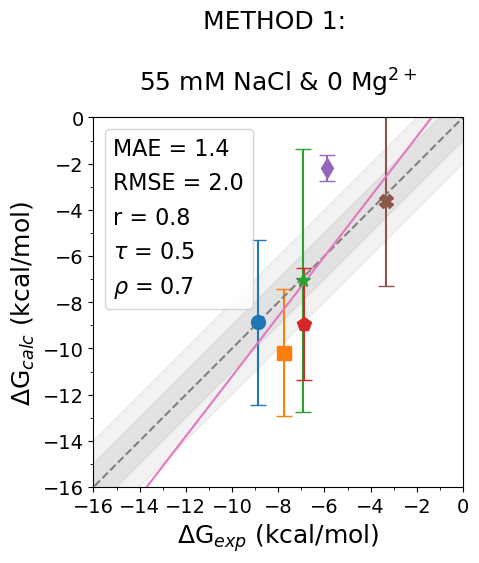

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


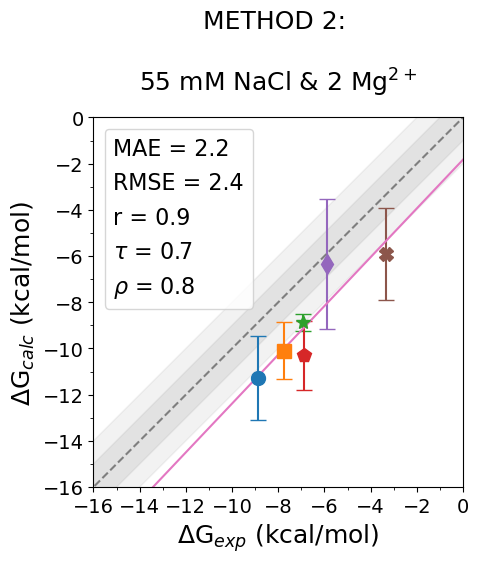

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


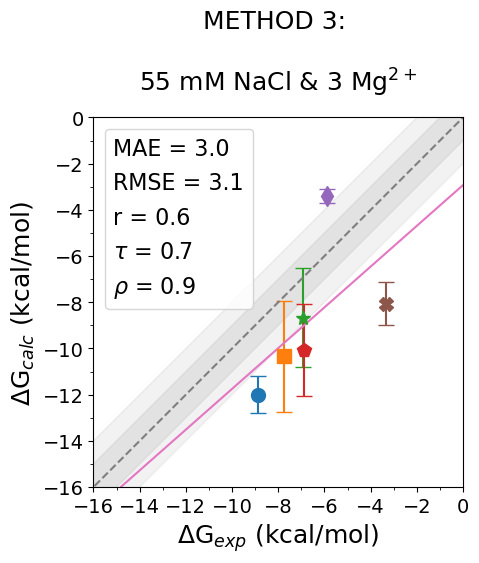

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


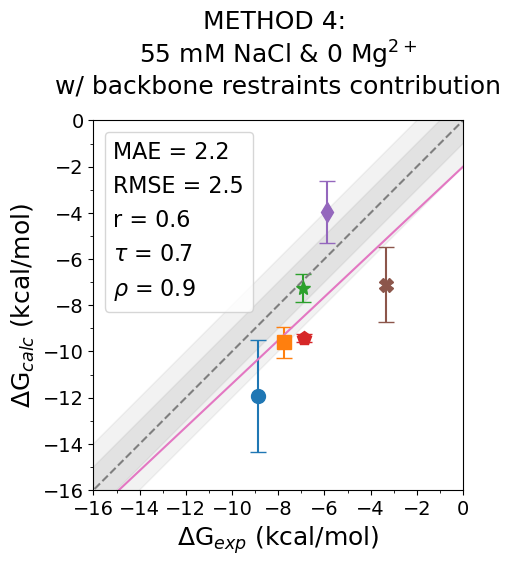

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


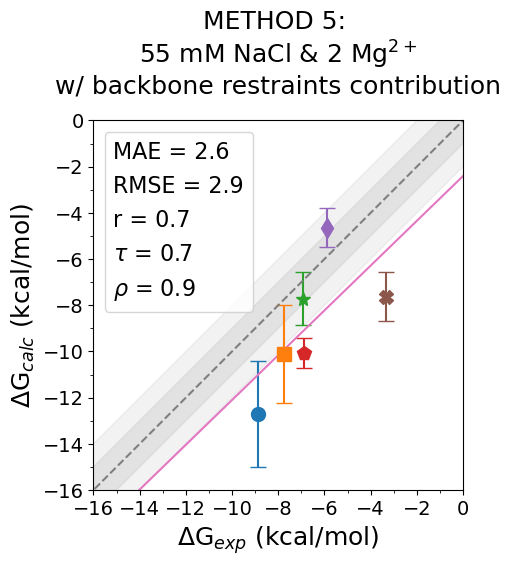

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


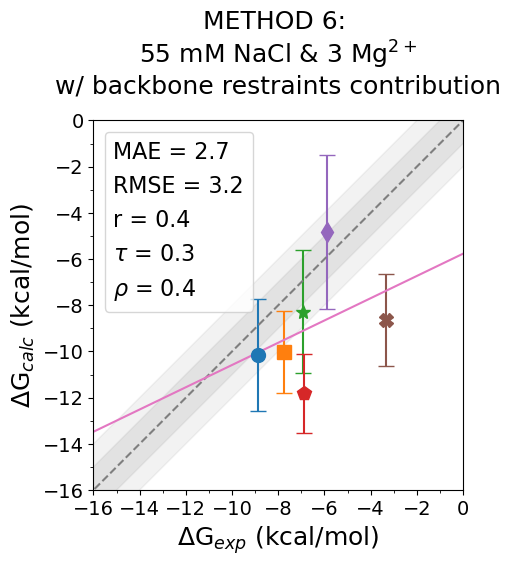

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


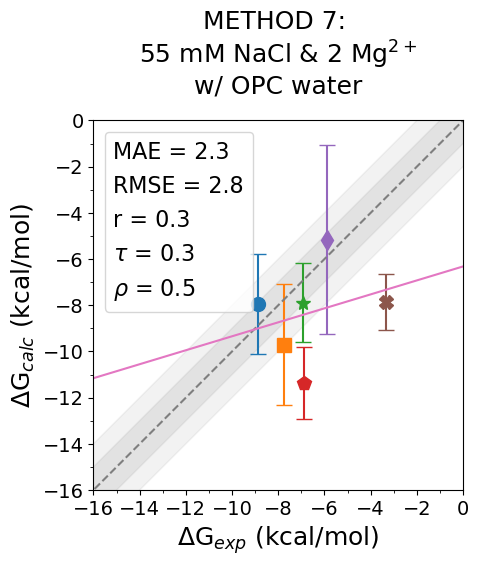

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


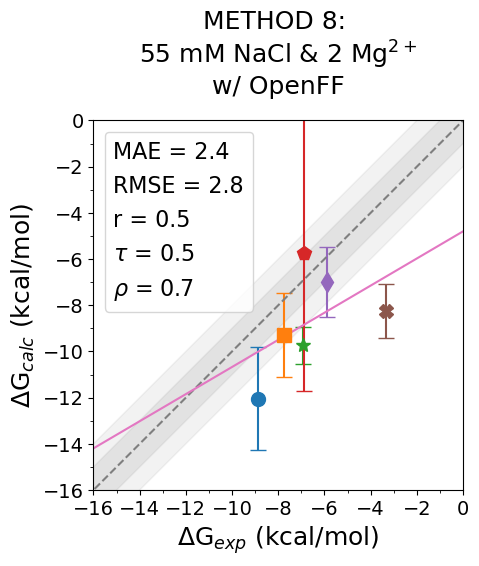

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


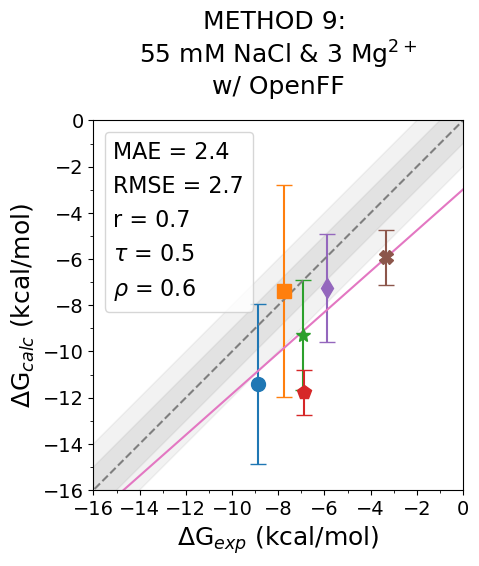

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


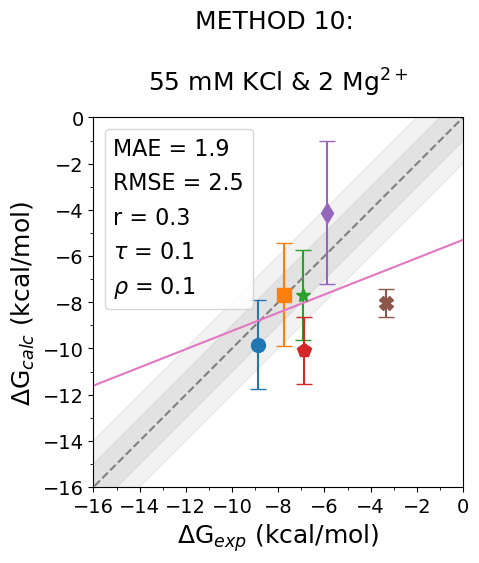

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


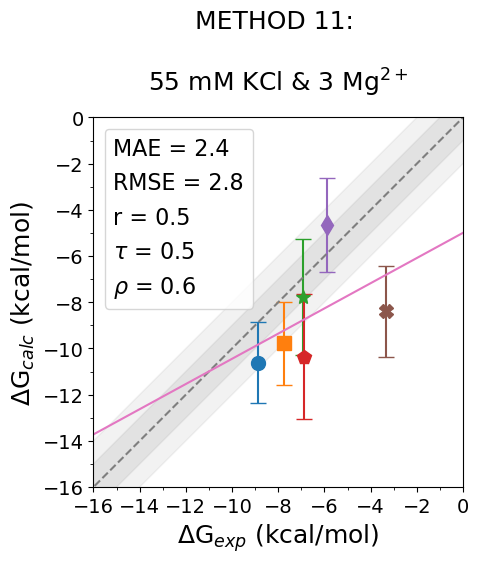

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


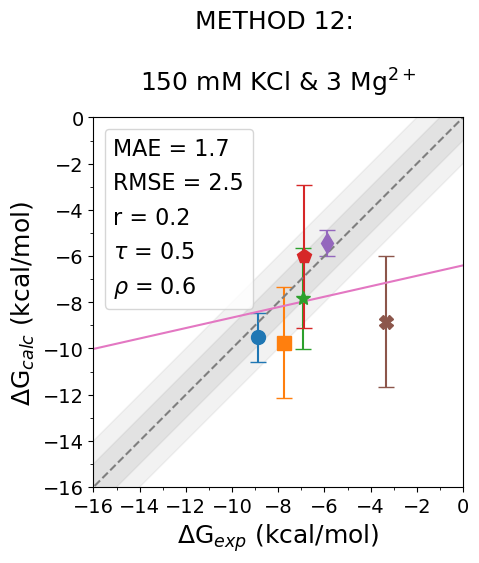

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


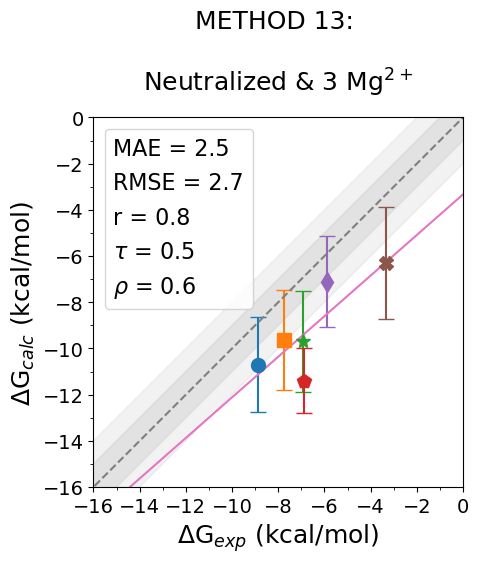

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


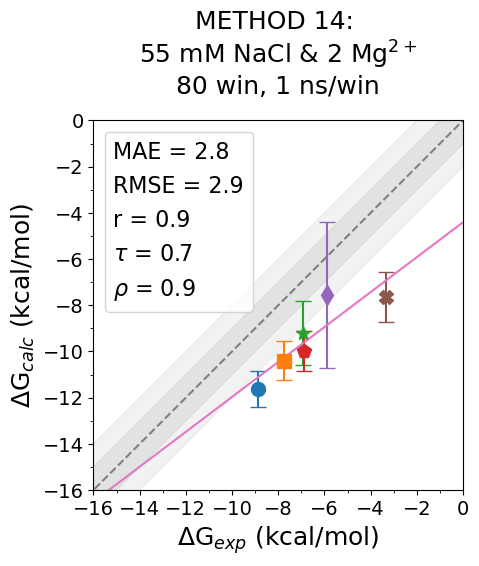

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


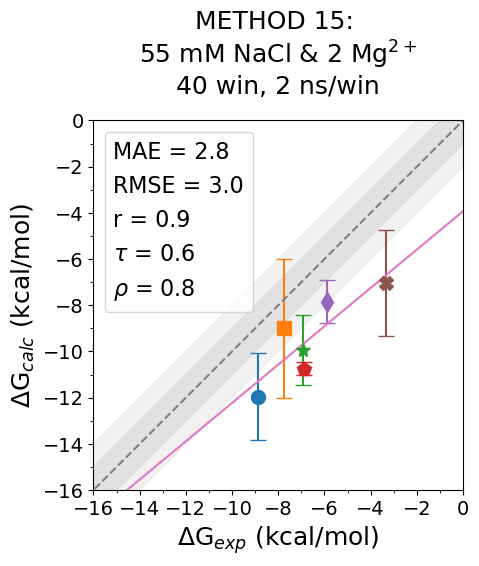

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


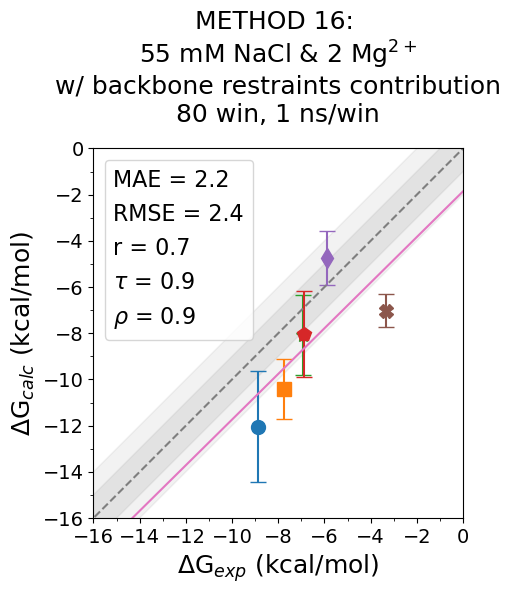

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


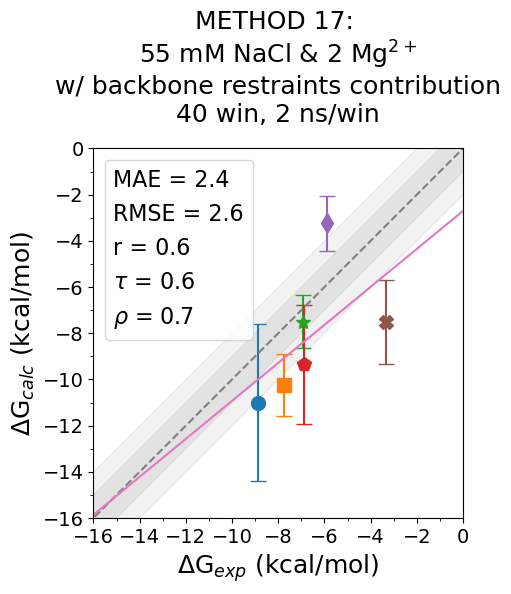

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


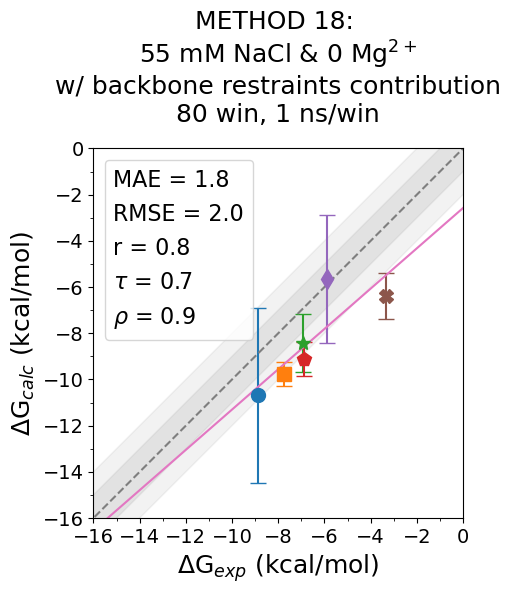

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


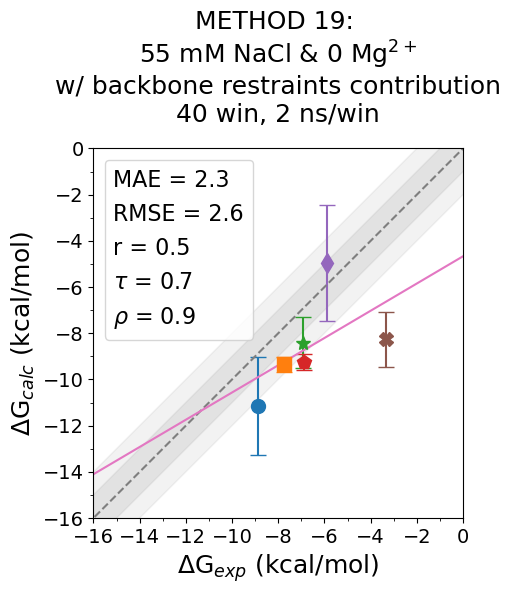

In [25]:
for key in file_dict.keys():
    path = os.path.join('./BFE_failed_rep/',key + '.txt')
    df = read_file(path)
    get_failure(df)
    write_accept_reject(df, file_dict[key][8],key)
    mean, std = get_mean_std(df, file_dict[key][6]) # second number is offset value (non-zero only for colvar bb rst.)
    cond_id = file_dict[key][9]
    file_dict = plotting(mean, std, file_dict, key, cond_id)

In [26]:
import csv
with open('my_dict.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Salt condition', '# of Mg', 'water model', 'Ligand\'s force field', '# windows', 'RNA backbone restraints', 'MAE', 'RMSE', 'r', 'Kenadall\'s tau', 'Spearman'])
    for name, data in file_dict.items():
        data = [f'{val:.1f}' if isinstance(val, float) else val for val in data]
        writer.writerow(data[:6] + data[9:])


In [27]:
df

ΔG(site,couple)  error(site,couple)  ΔG(site,c+o+a+r)  \
cmpnd            rep                                                           
theophylline     rep1      -203.340905            0.820486         -9.164181   
                 rep2      -203.343779            0.832369        -12.892769   
                 rep3      -202.366479            0.461571         -9.951991   
1_methylxanthine rep1      -246.412963            0.795797        -11.606633   
                 rep2      -247.159231            1.219710        -10.342650   
                 rep3      -246.872041            0.783812        -10.736806   
3_methylxanthine rep1      -256.127877            0.664147         -9.462089   
                 rep2      -255.875369            0.983843         -9.827077   
                 rep3      -255.490603            0.454111        -10.706328   
hypoxanthine     rep1      -183.785627            1.413240         -9.222260   
                 rep2      -185.688181            0.478838        -10.395685   
                 rep3      -185.676540            0.775259        -12.342699   
xanthine         rep1      -301.218736            0.903735        -10.621832   
                 rep2      -301.055585            0.866741         -8.875977   
                 rep3      -302.519827            0.993962         -9.088093   
caffeine         rep1      -200.524696            0.682020         -9.355040   
                 rep2      -200.332195            0.489491         -9.016333   
                 rep3      -199.988397            0.534552        -11.408399   

                       error(site,c+o+a+r)  ΔG(bulk,decouple)  \
cmpnd            rep                                            
theophylline     rep1             0.076682         181.226853   
                 rep2             5.175768         181.464540   
                 rep3             0.039617         181.274646   
1_methylxanthine rep1             2.309908         227.281579   
                 rep2             0.724907         227.451220   
                 rep3             0.299624         227.439010   
3_methylxanthine rep1             0.646860         235.274825   
                 rep2             0.180152         235.354331   
                 rep3             0.662795         235.279126   
hypoxanthine     rep1             0.555157         169.511432   
                 rep2             1.020940         169.571916   
                 rep3             0.297582         169.485940   
xanthine         rep1             1.281602         281.552394   
                 rep2             0.223460         281.578339   
                 rep3             1.658558         281.461506   
caffeine         rep1             1.146679         180.714224   
                 rep2             0.344891         180.915506   
                 rep3             0.582918         180.774579   

                       error(bulk,decouple)  ΔG(bulk,c)  error(bulk,c)  \
cmpnd            rep                                                     
theophylline     rep1              0.109741    0.102010       0.000115   
                 rep2              0.103540    0.107235       0.000021   
                 rep3              0.089021    0.099965       0.000151   
1_methylxanthine rep1              0.125316    0.117924       0.000081   
                 rep2              0.085136    0.070104       0.000197   
                 rep3              0.108087    0.093307       0.000350   
3_methylxanthine rep1              0.094009    0.080495       0.000039   
                 rep2              0.097727    0.073379       0.000008   
                 rep3              0.073822    0.082285       0.000094   
hypoxanthine     rep1              0.059771    0.056163       0.000036   
                 rep2              0.104076    0.047162       0.000035   
                 rep3              0.074362    0.051666       0.000030   
xanthine         rep1              0.111933    0.067073       0.000005   
           

#### MMGBSA ANALYSIS 

In [28]:
file_dict_mmgbsa = {
    #                                    salt cond.   # Mg   water.  lig ff    windows         BB rest. offset         title                     Dir name    Cond ID          
    'MMGBSA_for_RNA_salt_Mg'            :['55 NaCl',     '2', 'TIP3P', 'GAFF2', 'MM-GBSA','No', 0,  "55 mM NaCl & 2 Mg$^{2+}$\n MM-GBSA", 'MMGBSA', '20'],
    'MMGBSA_for_RNA_salt'               :['55 NaCl',     '0', 'TIP3P', 'GAFF2', 'MM-GBSA','No', 0,  "55 mM NaCl & 0 Mg$^{2+}$\n MM-GBSA", 'MMGBSA', '21'],
}

MMGBSA/MMGBSA_for_RNA_salt_Mg.txt
['theophylline', '1_methylxanthine', '3_methylxanthine', 'hypoxanthine', 'xanthine', 'caffeine']


/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:144: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


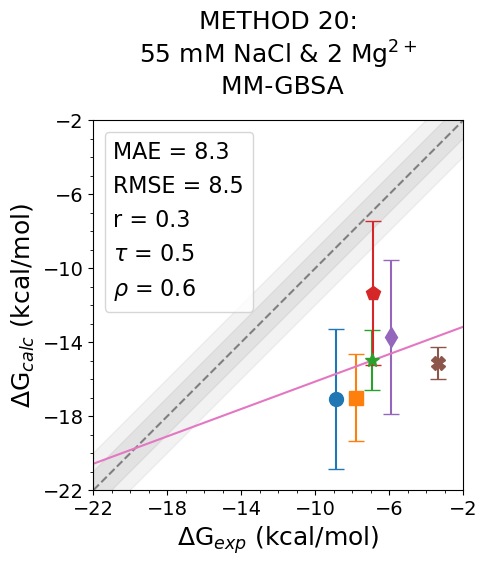

MMGBSA/MMGBSA_for_RNA_salt.txt
['theophylline', '1_methylxanthine', '3_methylxanthine', 'hypoxanthine', 'xanthine', 'caffeine']


/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_19268/228304089.py:144: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in l.legendHandles:


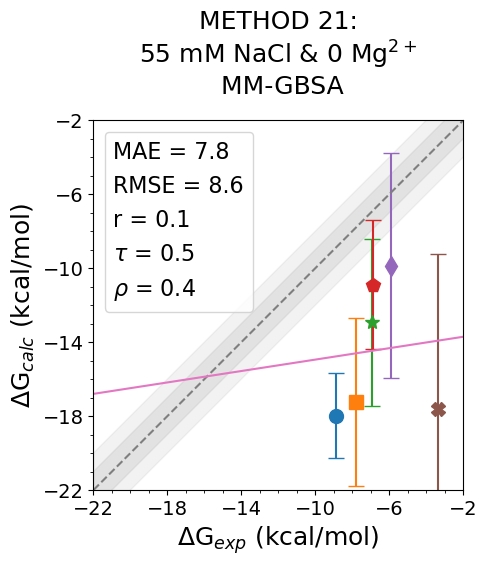

In [29]:
for key in file_dict_mmgbsa.keys():
    directory = file_dict_mmgbsa[key][-2]
    path = os.path.join(directory, key + '.txt')
    print(path)
    df = read_file(path)
    #display(df.index)

    # Get compound names from file
    compound_names = []
    for tuple in df.index:
        # Capture names only for 1st replicate
        i = tuple[1]
        if i == 1:
            compound_names.append(tuple[0])
    print(compound_names)
    
    # Ged mean and std values for free energy predictions
    mean = np.zeros(6)
    std = np.zeros(6)
    for i,cmp in enumerate(compound_names):
        mean[i] = df.loc[cmp]['_G (MMGBSA)'].mean()
        std[i] = df.loc[cmp]['_G (MMGBSA)'].std()

    cond_id = file_dict_mmgbsa[key][9]
    file_dict_mmgbsa = plotting_mmgbsa(mean, std, file_dict_mmgbsa, key, cond_id)

In [30]:
# with open('results_table.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['Salt condition', '# of Mg', 'water model', 'Ligand\'s force field', '# windows', 'RNA backbone restraints', 'MAE', 'RMSE', 'r', 'Kenadall\'s tau', 'Spearman'])
#     for name, data in file_dict.items():
#         data = [f'{val:.1f}' if isinstance(val, float) else val for val in data]
#         writer.writerow(data[:6] + data[9:])

In [31]:
# # Merge two dictionaries
file_dict.update(file_dict_mmgbsa)

# Convert dictionary to pandas dataframe
df_results = pd.DataFrame.from_dict(file_dict, orient='index')

# Reset the index
df_results.reset_index(inplace=True)

# Rename the columns  salt cond.   # Mg   water.  lig ff    windows         BB rest. offset         title                     Dir name    Cond ID       
df_results.columns = ['Filename', 'Salt Condition', '# of Mg', 'Water Model', 'Ligand Force Field', '# windows', 'RNA Backbone Restraints', 'DG contribution of BB Restraint for RNA onlt', 'Title', 'Directory Name', 'Condition ID', 'MAE', 'RMSE', "Pearson's r", 'Kenadall\'s Tau', "Spearman's Rho"]
display(df_results)


,Filename,Salt Condition,# of Mg,Water Model,Ligand Force Field,# windows,RNA Backbone Restraints,DG contribution of BB Restraint for RNA onlt,Title,Directory Name,Condition ID,MAE,RMSE,Pearson's r,Kenadall's Tau,Spearman's Rho
0,55_NaCl_0Mg_TP3_GAF_40_1ns_unres,55 NaCl,0,TIP3P,GAFF2,"40 win, 1 ns/win",No,0.0,\n55 mM NaCl & 0 Mg$^{2+}$,4-55NaCl/1-40winCmplx_30winLig,1,1.422098,1.981867,0.760280,0.466667,0.657143
1,55_NaCl_2Mg_TP3_GAF_40_1ns_unres,55 NaCl,2,TIP3P,GAFF2,"40 win, 1 ns/win",No,0.0,\n55 mM NaCl & 2 Mg$^{2+}$,3-55NaCl_Mg/1-40winCmplx_30winLig,2,2.195658,2.369034,0.899022,0.733333,0.828571
2,55_NaCl_3Mg_TP3_GAF_40_1ns_unres,55 NaCl,3,TIP3P,GAFF2,"40 win, 1 ns/win",No,0.0,\n55 mM NaCl & 3 Mg$^{2+}$,1-55NaCl_3Mg/1-40winCmplx_30winLig,3,2.972986,3.109466,0.561025,0.733333,0.885714
3,55_NaCl_0Mg_TP3_GAF_40_1ns_BBres,55 NaCl,0,TIP3P,GAFF2,"40 win, 1 ns/win",Yes,9.4,55 mM NaCl & 0 Mg$^{2+}$\nw/ backbone restrain...,9-5NaCl_bb_colvar/1-40winCmplx_30winLig,4,2.239215,2.483908,0.648667,0.733333,0.885714
4,55_NaCl_2Mg_TP3_GAF_40_1ns_BBres,55 NaCl,2,TIP3P,GAFF2,"40 win, 1 ns/win",Yes,9.7,55 mM NaCl & 2 Mg$^{2+}$\nw/ backbone restrain...,8-5NaCl_Mg_bb_colvar/1-40winCmplx_30winLig,5,2.615582,2.913256,0.658712,0.733333,0.885714
5,55_NaCl_3Mg_TP3_GAF_40_1ns_BBres,55 NaCl,3,TIP3P,GAFF2,"40 win, 1 ns/win",Yes,10.0,55 mM NaCl & 3 Mg$^{2+}$\nw/ backbone restrain...,4-55NaCl_3Mg_bb_colvar/1-40winCmplx_30winLig,6,2.696504,3.212876,0.381182,0.333333,0.428571
6,55_NaCl_2Mg_OPC_GAF_40_1ns_unres,55 NaCl,2,OPC,GAFF2,"40 win, 1 ns/win",No,0.0,55 mM NaCl & 2 Mg$^{2+}$\nw/ OPC water,3-55NaCl_Mg/6-opc_40winCmplx_30winLig,7,2.251809,2.776828,0.273283,0.333333,0.542857
7,55_NaCl_2Mg_TP3_OFF_40_1ns_unres,55 NaCl,2,TIP3P,OpenFF,"40 win, 1 ns/win",No,0.0,55 mM NaCl & 2 Mg$^{2+}$\nw/ OpenFF,3-55NaCl_Mg/2-OpenFF_40winCmplx_30winLig,8,2.447935,2.800530,0.500912,0.466667,0.714286
8,55_NaCl_3Mg_TP3_OFF_40_1ns_unres,55 NaCl,3,TIP3P,OpenFF,"40 win, 1 ns/win",No,0.0,55 mM NaCl & 3 Mg$^{2+}$\nw/ OpenFF,1-55NaCl_3Mg/2-OpenFF_40winCmplx_30winLig,9,2.360973,2.732983,0.696462,0.466667,0.600000
9,55_KCl_2Mg_TP3_GAF_40_1ns_unres,55 KCl,2,TIP3P,GAFF2,"40 win, 1 ns/win",No,0.0,\n55 mM KCl & 2 Mg$^{2+}$,10-55KCl_Mg/1-40winCmplx_30winLig,10,1.914953,2.474884,0.346933,0.066667,0.142857


In [32]:
# Select and order columns of interest for Table 1 in paper
df_results_table = df_results[['Condition ID', 'Salt Condition',  '# of Mg', 'Water Model', 'Ligand Force Field', '# windows', 'RNA Backbone Restraints', 'MAE', 'RMSE', "Pearson's r", 'Kenadall\'s Tau', "Spearman's Rho"]].copy()
# Round numbers in stats columns into one decimal
cols_to_round = [ 'MAE', 'RMSE', "Pearson's r", 'Kenadall\'s Tau', "Spearman's Rho"]
df_results_table[cols_to_round] = df_results_table[cols_to_round].round(1)
display(df_results_table)

# Write table to file
df_results_table.to_csv('results_table.csv', index=False)

,Condition ID,Salt Condition,# of Mg,Water Model,Ligand Force Field,# windows,RNA Backbone Restraints,MAE,RMSE,Pearson's r,Kenadall's Tau,Spearman's Rho
0,1,55 NaCl,0,TIP3P,GAFF2,"40 win, 1 ns/win",No,1.4,2.0,0.8,0.5,0.7
1,2,55 NaCl,2,TIP3P,GAFF2,"40 win, 1 ns/win",No,2.2,2.4,0.9,0.7,0.8
2,3,55 NaCl,3,TIP3P,GAFF2,"40 win, 1 ns/win",No,3.0,3.1,0.6,0.7,0.9
3,4,55 NaCl,0,TIP3P,GAFF2,"40 win, 1 ns/win",Yes,2.2,2.5,0.6,0.7,0.9
4,5,55 NaCl,2,TIP3P,GAFF2,"40 win, 1 ns/win",Yes,2.6,2.9,0.7,0.7,0.9
5,6,55 NaCl,3,TIP3P,GAFF2,"40 win, 1 ns/win",Yes,2.7,3.2,0.4,0.3,0.4
6,7,55 NaCl,2,OPC,GAFF2,"40 win, 1 ns/win",No,2.3,2.8,0.3,0.3,0.5
7,8,55 NaCl,2,TIP3P,OpenFF,"40 win, 1 ns/win",No,2.4,2.8,0.5,0.5,0.7
8,9,55 NaCl,3,TIP3P,OpenFF,"40 win, 1 ns/win",No,2.4,2.7,0.7,0.5,0.6
9,10,55 KCl,2,TIP3P,GAFF2,"40 win, 1 ns/win",No,1.9,2.5,0.3,0.1,0.1
